In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os

np.random.seed(1)
torch.manual_seed(1)

In [4]:
# Define Force Field
def f(x):
    m1 = 1; m2 = 1; g = 1; l1 = 1; l2 = 1
    a1 = x[:,0]/torch.sqrt(torch.tensor(g,dtype=torch.float))
    w1 = x[:,1]
    a2 = x[:,2]/torch.sqrt(torch.tensor(g,dtype=torch.float))
    w2 = x[:,3]
    beta1 = (m2*l1*w1**2*torch.sin(a2-a1)*torch.cos(a2-a1)+m2*g*torch.sin(a2)*torch.cos(a2-a1)+m2*l2*w2**2*torch.sin(a2-a1)-(m1+m2)*g*torch.sin(a1))/((m1+m2)*l1-m2*l1*torch.cos(a2-a1)**2)
    beta2 = (-m2*l2*w2**2*torch.sin(a2-a1)*torch.cos(a2-a1)+(m1+m2)*(g*torch.sin(a1)*torch.cos(a2-a1)-l1*w1**2*torch.sin(a2-a1)-g*torch.sin(a2)))/((m1+m2)*l1-m2*l1*torch.cos(a2-a1)**2)
    return torch.transpose(torch.stack([torch.sqrt(torch.tensor(g,dtype=torch.float))*w1,beta1,torch.sqrt(torch.tensor(g,dtype=torch.float))*w2,beta2]),0,1)


input_ = torch.normal(0,1,size=(1000,4), requires_grad=True)*0.1
#input_ = (torch.rand(1000,4, requires_grad=True)-0.5)*2*1

input_d = input_.shape[1]

def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# Define Transformer

class T(nn.Module):
    def __init__(self,w=200):
        super(T, self).__init__()
        self.l1 = nn.Linear(input_d,w)
        self.l2 = nn.Linear(w,w)
        self.l23 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,input_d)
    
    def forward(self, x, eps=1.0):
        bs = x.shape[0]
        #f = nn.Tanh()
        f = nn.SiLU()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x23 = f(self.l23(self.x2))
        self.x3 = self.l3(self.x23)
        return x + eps*self.x3
    
    #def forward(self, x, eps=0.0):
    #    return self.l0(x)
    
    def transform_f(self, x):
        jac_ts = batch_jacobian(self.forward, x, create_graph=True)
        return torch.matmul(jac_ts, torch.unsqueeze(f(x), dim=2))

In [5]:
# Loss library

# Lie group: for SO(2), g_J = [[0,1],[-1,0]]

def Jp_(f,t,inputs):
    input_d = input_.shape[1]
    jac_f = batch_jacobian(f,inputs,create_graph=True)
    jac_ts = batch_jacobian(t,inputs,create_graph=True)
    jac_inv_ts = torch.inverse(jac_ts)

    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_ts[:,i,j], inputs, torch.ones_like(jac_ts[:,i,j]), create_graph=True, retain_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)

    # calculate J'
    Jp1 = jac_inv_ts.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=4)*hess_t.permute(0,2,1,3).unsqueeze(dim=2)*f(inputs).unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=3)
    Jp2 = jac_inv_ts.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=4)*jac_ts.unsqueeze(dim=2).unsqueeze(dim=3)*jac_f.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=2)
    Jp = Jp1 + Jp2
    Jp = torch.sum(torch.sum(Jp,dim=4),dim=3)
    return Jp

def hess(t, inputs):
    jac_ts = batch_jacobian(t,inputs,create_graph=True)
    
    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_ts[:,i,j], inputs, torch.ones_like(jac_ts[:,i,j]), create_graph=True, retain_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)
    
    return hess_t
    

def off_diag(M,n_part=[2,2]):
    bs = M.shape[0]
    input_d = M.shape[1]
    assert input_d == np.sum(n_part)
    start = 0
    end = n_part[0]
    diag_loss = 0
    for i in range(len(n_part)):
        diag_loss = diag_loss + torch.sum(M[:,start:end, start:end]**2)
        start = end
        end = end + n_part[i]
    return (torch.sum(M**2) - diag_loss)/(batch_size*input_d**2)


def lie_loss(f,t,inputs):
    
    bs = inputs.shape[0]
    # for SO(2)
    g_J = torch.tensor([[0,1],[-1,0]], dtype=torch.float, requires_grad=True)
    Jp = Jp_(f,t,inputs)
    fp = t.transform_f(inputs)
    inputsp = torch.unsqueeze(t(inputs), dim=2)
    
    g_J = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=1) * torch.unsqueeze(g_J, dim=0)
    pde = torch.matmul(torch.matmul(Jp.permute(0,1,2),g_J),inputsp) - torch.matmul(g_J, fp)
    r_mse = torch.mean(inputsp**2)
    loss = torch.mean(pde**2)
    return loss/r_mse

def translation_loss(f,t,inputs):
    Jp = Jp_(f,t,inputs)[:,0]
    loss = torch.mean(Jp**2)
    return loss

def modularity_loss(f,t,inputs,n_part=[2,2]):
    Jp = Jp_(f,t,inputs)
    loss = off_diag(Jp,n_part=n_part)
    return loss

def hamiltonicity_loss(f,t,inputs):
    Jp = Jp_(f,t,inputs)
    input_d = inputs.shape[1]
    assert input_d % 2 ==0
    M = torch.zeros(input_d, input_d)
    half_d = int(input_d/2)
    M[:half_d, half_d:] = torch.eye(half_d)
    M[half_d:, :half_d] = -torch.eye(half_d)
    M = torch.tensor(M, dtype=torch.float, requires_grad=True)
    JMMJ = torch.matmul(Jp.permute(0,2,1), M) + torch.matmul(M, Jp)
    loss = torch.mean(JMMJ**2)
    return loss

In [6]:
# Training a transformer to minimize PDE losses


np.random.seed(0)
torch.manual_seed(0)

t = T(w=400)
epochs = 5000
switch_epoch = 2500
lr_decay_epoch = 500

n_train = input_.shape[0]
batch_size = 128

lr = 1e-3
optimizer = optim.Adam(t.parameters(), lr=lr)

log = 10

losses_ham = [] # hamiltonicity
losses_mod = [] # modularity

for epoch in range(epochs):

    t.train()
    optimizer.zero_grad()
    
    if epoch == 1000 or epoch == 2000:
        lr = lr*0.5
        optimizer = optim.Adam(t.parameters(), lr=lr)
    
    choices = np.random.choice(n_train, batch_size)
    inputs = input_[choices]
    
    if epoch == switch_epoch:
        for opt_param in optimizer.param_groups:
            lr = 1e-3
            opt_param['lr'] = lr
    
    if (epoch+1) % lr_decay_epoch == 0:
        for opt_param in optimizer.param_groups:
            lr = lr * 0.5
            opt_param['lr'] = lr
    
    if epoch < switch_epoch:
        loss_ham = hamiltonicity_loss(f,t,inputs)
        loss_mod = float("nan")
        losses_ham.append(loss_ham.detach().numpy())
        losses_mod.append(loss_mod)
        loss = loss_ham
    else:
        loss_ham = hamiltonicity_loss(f,t,inputs)
        loss_mod = modularity_loss(f,t,inputs,n_part=[2,2])
        losses_ham.append(loss_ham.detach().numpy())
        losses_mod.append(loss_mod.detach().numpy())
        loss = loss_ham + loss_mod
        
    loss.backward(retain_graph=True)
    #loss.backward()
    optimizer.step()
    
    if epoch%log == 0:
        print('Epoch:  %d | Loss_ham: %.4f | Loss_mod: %.4f' %(epoch, loss_ham, loss_mod))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  0 | Loss_ham: 0.7399 | Loss_mod: nan
Epoch:  10 | Loss_ham: 0.1201 | Loss_mod: nan
Epoch:  20 | Loss_ham: 0.1360 | Loss_mod: nan
Epoch:  30 | Loss_ham: 0.0767 | Loss_mod: nan
Epoch:  40 | Loss_ham: 0.0692 | Loss_mod: nan
Epoch:  50 | Loss_ham: 0.0501 | Loss_mod: nan
Epoch:  60 | Loss_ham: 0.0462 | Loss_mod: nan
Epoch:  70 | Loss_ham: 0.0282 | Loss_mod: nan
Epoch:  80 | Loss_ham: 0.0057 | Loss_mod: nan
Epoch:  90 | Loss_ham: 0.0033 | Loss_mod: nan
Epoch:  100 | Loss_ham: 0.0016 | Loss_mod: nan
Epoch:  110 | Loss_ham: 0.0013 | Loss_mod: nan
Epoch:  120 | Loss_ham: 0.0012 | Loss_mod: nan
Epoch:  130 | Loss_ham: 0.0008 | Loss_mod: nan
Epoch:  140 | Loss_ham: 0.0009 | Loss_mod: nan
Epoch:  150 | Loss_ham: 0.0010 | Loss_mod: nan
Epoch:  160 | Loss_ham: 0.0008 | Loss_mod: nan
Epoch:  170 | Loss_ham: 0.0007 | Loss_mod: nan
Epoch:  180 | Loss_ham: 0.0008 | Loss_mod: nan
Epoch:  190 | Loss_ham: 0.0007 | Loss_mod: nan
Epoch:  200 | Loss_ham: 0.0006 | Loss_mod: nan
Epoch:  210 | Loss_ham: 

Epoch:  1730 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1740 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1750 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1760 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1770 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1780 | Loss_ham: 0.0004 | Loss_mod: nan
Epoch:  1790 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1800 | Loss_ham: 0.0004 | Loss_mod: nan
Epoch:  1810 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1820 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1830 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1840 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1850 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1860 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1870 | Loss_ham: 0.0004 | Loss_mod: nan
Epoch:  1880 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1890 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1900 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1910 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1920 | Loss_ham: 0.0003 | Loss_mod: nan
Epoch:  1930 | Loss_ham: 0.0004 | Loss_m

Epoch:  4980 | Loss_ham: 0.0002 | Loss_mod: 0.0008
Epoch:  4990 | Loss_ham: 0.0003 | Loss_mod: 0.0007


In [9]:
np.save('2d_dp_results/0.1.npy', np.array([np.array(losses_ham),np.array(losses_mod)]))

In [10]:
loss = np.load('2d_dp_results/0.1.npy')
losses_ham = loss[0]
losses_mod = loss[1]

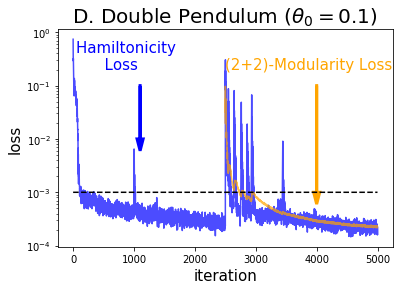

In [18]:
plt.plot(np.arange(epochs), losses_ham, color="blue",alpha=0.7)
plt.plot(np.arange(epochs), losses_mod*0.3, color="orange",alpha=0.7)
#plt.plot(np.arange(400), losses_tran)
#plt.legend(["hamiltonicity_loss","modularity_loss"],fontsize=15)
plt.xlabel("iteration",fontsize=15)
plt.ylabel("loss",fontsize=15)
plt.title("D. Double Pendulum "+r"$(\theta_0=0.1)$",fontsize=20)
plt.arrow(1100,0.1,0,-0.09,head_width=100,head_length=0.004,linewidth=3, color="blue")
plt.text(50,0.2,"Hamiltonicity \n      Loss",fontsize=15, color="blue")
plt.arrow(4000,0.1,0,-0.099,head_width=100,head_length=0.0004,linewidth=3, color="orange")
plt.text(2500,0.2,"(2+2)-Modularity Loss",fontsize=15, color="orange")
plt.plot(np.arange(epochs),np.ones(epochs,)*1e-3,ls="--",color="black")
plt.yscale('log')
plt.savefig("../examples/figures/dp.pdf", bbox_inches="tight")